In [ ]:
!pip install kaggle

In [ ]:
! pip install -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.8 MB/s eta 0:00:00


In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend


keras starter 기반으로 작성된 노트북

Config

In [ ]:
class Config:
    SEED = 42
    IMAGE_SIZE = [256, 256]
    BATCH_SIZE = 8
    EPOCHS = 10
    TARGET_COLS = [
        "bowel_injury"]
    #EXTRA_TARGET_COLS = ["extravasation_injury"]
    #KIDNEY_TARGET_COLS = ["kidney_healthy", "kidney_low", "kidney_high"]
    #LIVER_TARGET_COLS = ["liver_healthy", "liver_low", "liver_high"]
    #SPLEEN_TARGET_COLS = ["spleen_healthy", "spleen_low", "spleen_high"]
    AUTOTUNE = tf.data.AUTOTUNE

config = Config()

In [ ]:
keras.utils.set_random_seed(seed=config.SEED)

Dataset
## png original 데이터

In [ ]:
BASE_PATH = "/content/drive/MyDrive/rsna_data"

In [ ]:
# CSV 파일을 읽어와서 데이터프레임 생성
train_df = pd.read_csv(f"{BASE_PATH}/train.csv")
series_meta_df = pd.read_csv(f"{BASE_PATH}/train_series_meta.csv")

# train.csv와 train_series_meta.csv를 patient_id를 기준으로 병합
dataframe = pd.merge(train_df, series_meta_df, on="patient_id")

# 이미지 경로 생성
dataframe["image_path"] = f"/content/drive/MyDrive/png_jjw"\
                    + "/" + dataframe.patient_id.astype(str)\
                    + "/" + dataframe.series_id.astype(str)\
                    + "/" + "img_256x256_d1_original"\
                    + "/" + "image_" + dataframe.groupby("series_id").cumcount().add(1).astype(str).str.zfill(3) + ".png"

# 중복 행 제거
dataframe = dataframe.drop_duplicates()

# 처음 2개 행 출력
dataframe.head(2)


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,aortic_hu,incomplete_organ,image_path
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,146.00,0,/content/drive/MyDrive/png_jjw/10004/21057/img...
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,51033,454.75,0,/content/drive/MyDrive/png_jjw/10004/51033/img...


In [ ]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

In [ ]:
train_data.shape, val_data.shape

((3745, 19), (966, 19))

In [ ]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)
    labels = 이 부분을 완성하세요.
    return (image, labels)

In [ ]:
import tensorflow as tf
import keras_cv.layers

# 레이어 외부에서 RandomFlip 레이어를 생성
random_flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
random_rotation_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)

class CustomAugmenter(tf.keras.layers.Layer):
    def __init__(self, cutout_params, **kwargs):
        super(CustomAugmenter, self).__init__(**kwargs)
        self.cutout_layer = keras_cv.layers.Augmenter([keras_cv.layers.RandomCutout(**cutout_params)])

    def call(self, inputs, training=None):
        if training:
            inputs = random_flip_layer(inputs)
            inputs = random_rotation_layer(inputs)
            inputs = self.cutout_layer(inputs)
        return inputs

def apply_augmentation(images, labels):
    # 이미지 증강 파이프라인을 정의합니다.
    augmenter = CustomAugmenter(cutout_params={"height_factor": 0.2, "width_factor": 0.2})

    # 이미지 증강을 적용합니다.
    augmented_images = augmenter(images, training=True)


    return (augmented_images, labels)


In [ ]:
def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=config.AUTOTUNE)  # 이미지 증강 적용
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [ ]:
paths = train_data.image_path.tolist()

#각 라벨과 데이터 셋 만들어주기
bowel_labels = train_data[config.BOWEL_TARGET_COLS].values
bowel_ds = build_dataset(image_paths=paths, labels=bowel_labels)

extra_labels = train_data[config.EXTRA_TARGET_COLS].values
extra_ds = build_dataset(image_paths=paths, labels= extra_labels)

kidney_labels = train_data[config.KIDNEY_TARGET_COLS].values
kidney_ds = build_dataset(image_paths=paths, labels= kidney_labels)

liver_labels = train_data[config.LIVER_TARGET_COLS].values
liver_ds = build_dataset(image_paths=paths, labels= liver_labels)

spleen_labels = train_data[config.SPLEEN_TARGET_COLS].values
spleen_ds = build_dataset(image_paths=paths, labels= spleen_labels)

#예시
images, spleen_labels = next(iter(spleen_ds))
images.shape, [label.shape for label in spleen_labels]

TypeError: ignored

작업할 거
- image augmentation 부분 함수 나눠서 넣기 > 같은 이미지 셋으로 만들기 > 결과 csv에 한번에 넣기
- original / normalization 데이터 셋 나눠서 resnet 캐글 infer 넣고 확인 하기
- efficientNet backbone 캐글 넣어보기

Model

Bowel

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

def build_bowel_model(warmup_steps, decay_steps):
    # Define Input
    inputs = tf.keras.Input(shape=(256, 256, 3), batch_size=config.BATCH_SIZE)

    # Define a simple CNN model
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)

    # Define the bowel head for binary classification
    x_bowel = Dense(32, activation='relu')(x)
    out_bowel = Dense(1, name='bowel', activation='sigmoid')(x_bowel)

    # Create model
    print("[INFO] Building the model...")
    model = Model(inputs=inputs, outputs=out_bowel)

    # Cosine Decay
    cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model with accuracy as the metric
    optimizer = tf.keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel": tf.keras.losses.BinaryCrossentropy(),
    }
    metrics = {
        "bowel":["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    return model

Train

In [ ]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...
total_train_steps=-160
warmup_steps=-16
decay_steps=-144


In [ ]:
# build the model
print("[INFO] Building the model...")
model = build_bowel_model(warmup_steps, decay_steps)

# train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

[INFO] Building the model...
[INFO] Building the model...
[INFO] Compiling the model...
[INFO] Training...
Epoch 1/10
469/469 [==============================] - 437s 910ms/step - loss: 0.8542 - accuracy: 0.9818 - val_loss: 0.8077 - val_accuracy: 0.0269
Epoch 2/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1102 - accuracy: 0.9706 - val_loss: 0.4678 - val_accuracy: 0.9731
Epoch 3/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1581 - accuracy: 0.9792 - val_loss: 0.1489 - val_accuracy: 0.9731
Epoch 4/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1249 - accuracy: 0.9792 - val_loss: 0.1297 - val_accuracy: 0.9731
Epoch 5/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1176 - accuracy: 0.9792 - val_loss: 0.1271 - val_accuracy: 0.9731
Epoch 6/10
469/469 [==============================] - 12s 25ms/step - loss: 0.1168 - accuracy: 0.9792 - val_loss: 0.1256 - val_accuracy: 0.9731
Epoch 7/10
469/469 [=======

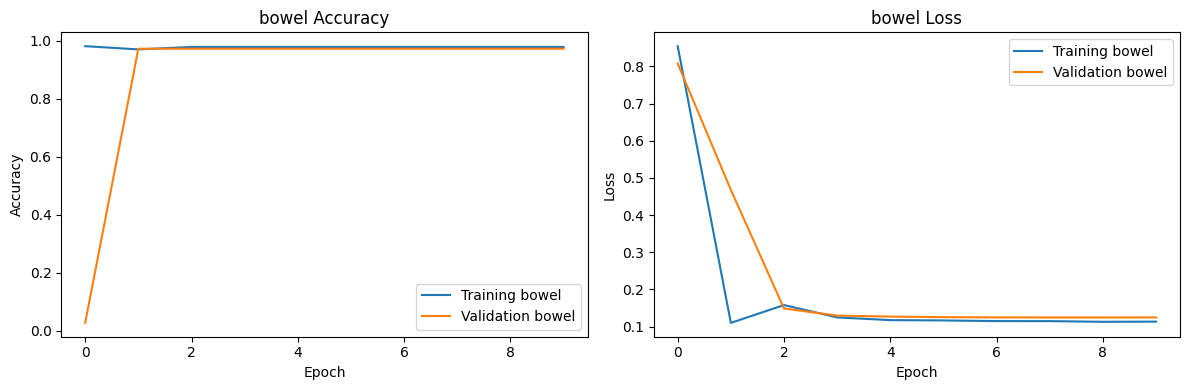

In [ ]:
import matplotlib.pyplot as plt

# Create a 1x2 grid for the subplots (one for accuracy and one for loss)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training accuracy for 'bowel' label
axes[0].plot(history.history['accuracy'], label='Training bowel')
# Plot validation accuracy for 'bowel' label
axes[0].plot(history.history['val_accuracy'], label='Validation bowel')
axes[0].set_title('bowel Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot training loss for 'bowel' label
axes[1].plot(history.history['loss'], label='Training bowel')
# Plot validation loss for 'bowel' label
axes[1].plot(history.history['val_loss'], label='Validation bowel')
axes[1].set_title('bowel Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# # store best results
# best_epoch = np.argmin(history.history['val_loss'])
# best_loss = history.history['val_loss'][best_epoch]
# best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
# best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
# best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
# best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
# best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# # Find mean accuracy
# best_acc = np.mean(
#     [best_acc_bowel,
#      best_acc_extra,
#      best_acc_liver,
#      best_acc_kidney,
#      best_acc_spleen
# ])


# print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
# print('ORGAN Acc:')
# print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
# print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
# print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
# print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
# print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')